In [2]:
%matplotlib inline
from logging import warning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn.linear_model as liner_model
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML,display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv('/home/teemo/ML/kaggle_competition/house-prices/train.csv')
test = pd.read_csv('/home/teemo/ML/kaggle_competition/house-prices/test.csv')

#pandas没有直接将字符串的字节保存在ndarray中，而是使用对象ndarray来保存指向对象的指针，因此，这种ndarray的dtype是object。表示字符串

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('Id')
quantitative.remove('SalePrice')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

<AxesSubplot:>

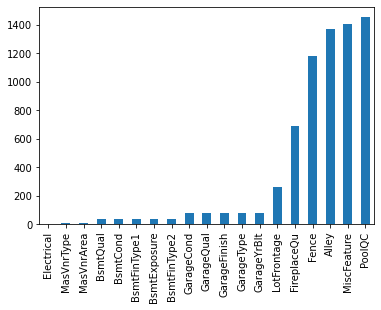

In [3]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

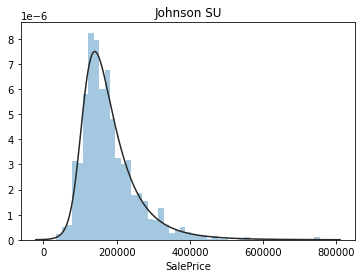

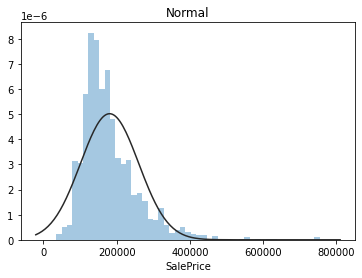

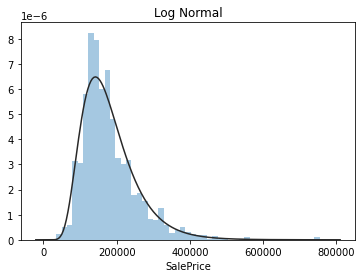

In [4]:
from matplotlib.pyplot import plot
import scipy.stats as st
y = train['SalePrice']
plt.figure(1);plt.title('Johnson SU')
sns.distplot(y,kde = False,fit = st.johnsonsu)
plt.figure(2);plt.title('Normal')
sns.distplot(y,kde = False,fit = st.norm)
plt.figure(3);plt.title('Log Normal')
sns.distplot(y,kde = False,fit = st.lognorm)


In [5]:
#所有数值型标量正态性检验
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


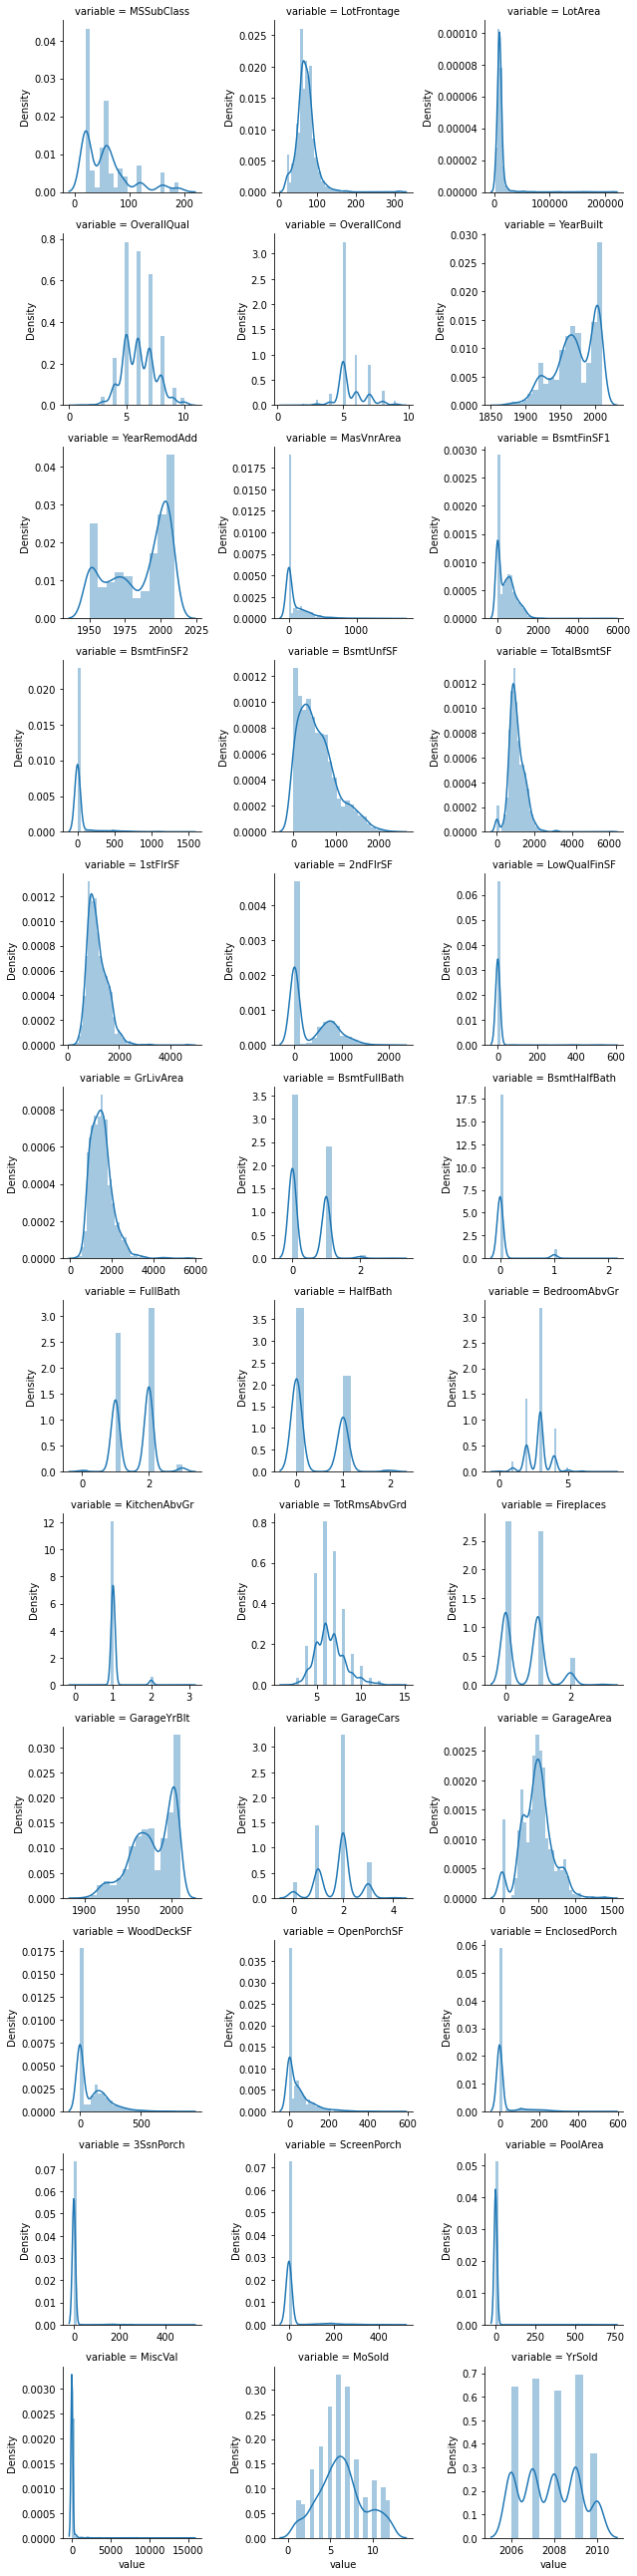

In [6]:
f = pd.melt(train,value_vars=quantitative)
g = sns.FacetGrid(f,col='variable',col_wrap=3,sharex=False,sharey=False)
g = g.map(sns.distplot,"value")

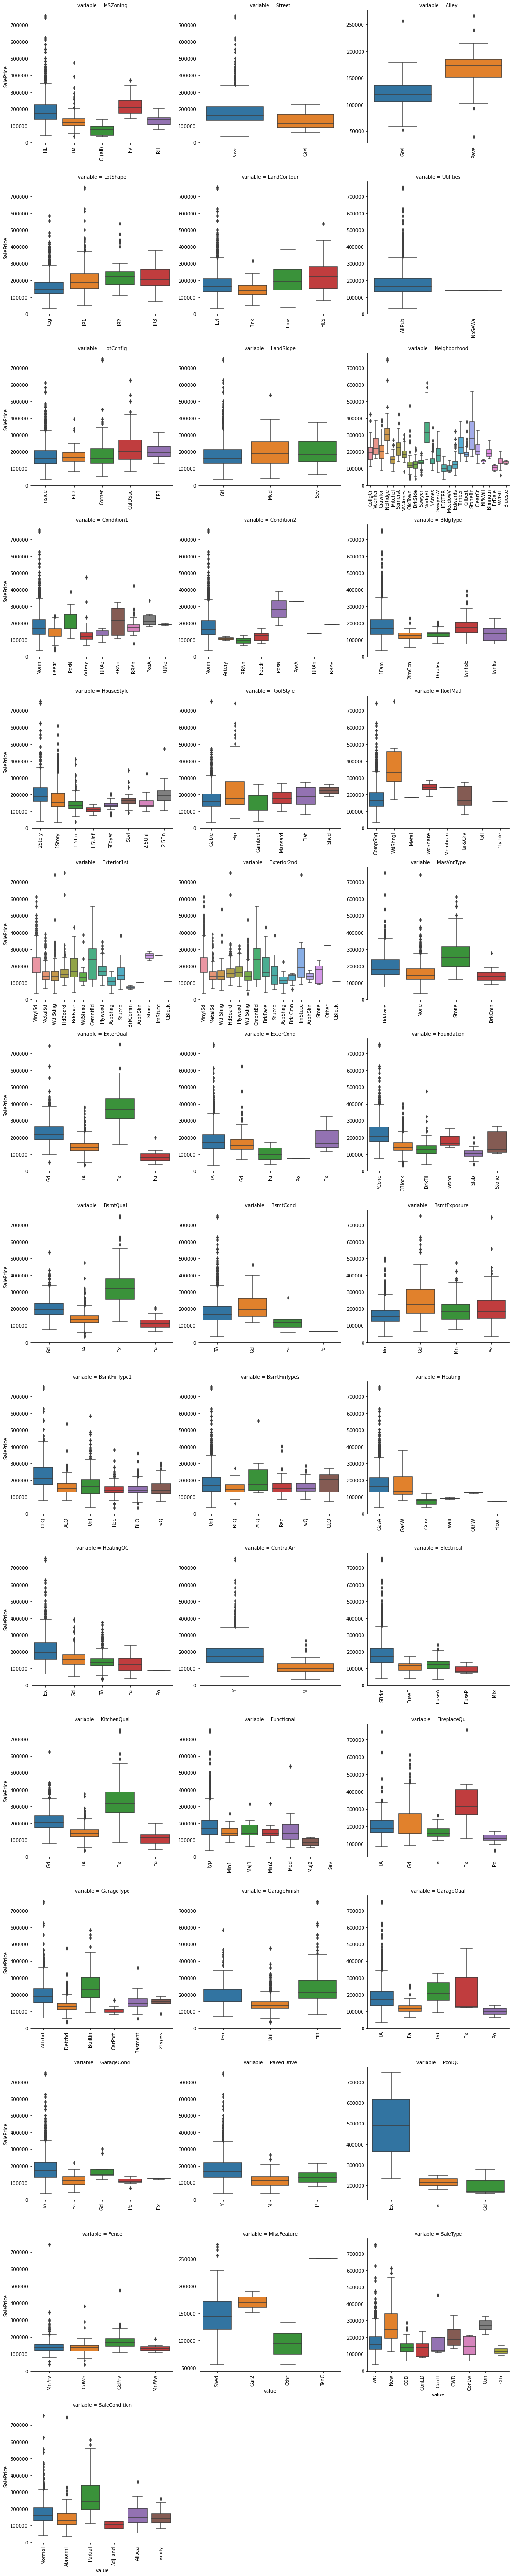

In [7]:
from pandas import isnull


for c in quantitative:
    #将数据类型转化为分类类型
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x = plt.xticks(rotation = 90)
f = pd.melt(train,id_vars= ['SalePrice'],value_vars=qualitative)
g = sns.FacetGrid(f,col = "variable",col_wrap=3,sharex = False,sharey=False,size=5)
g = g.map(boxplot,"value","SalePrice")

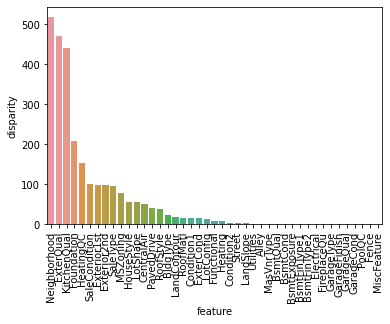

In [8]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)
        

In [9]:
#分类变量对销售价格影响的快速估计，使用方差分析检验集合是否具有相似分布(其实我没看懂这一步在干嘛)
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)
    

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


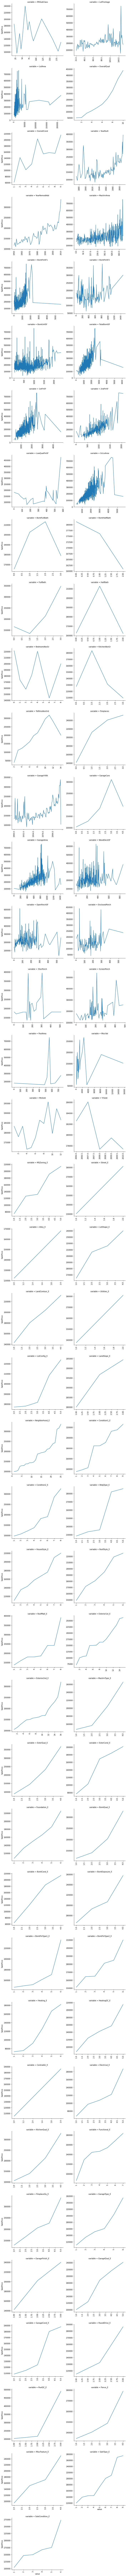

In [10]:

def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    #对x轴进行平均操作（就是把重复的值给去掉）
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['SalePrice'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")


<AxesSubplot:ylabel='Density'>

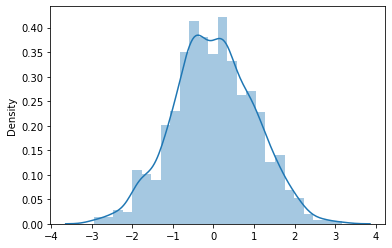

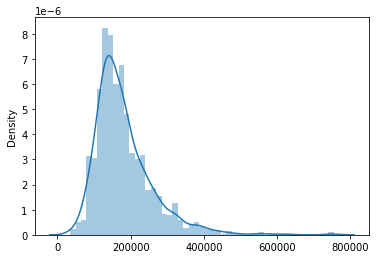

In [24]:
y = train['SalePrice'].values
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)